In [1]:
import sys
sys.path.insert(0, r'../../../quetzal')

from quetzal.model import stepmodel
from quetzal.io import excel
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.plot

%matplotlib inline

SQLalchemy is not installed. No support for SQL output.


In [2]:
scenario = 'polycentric1'

In [3]:
vol = stepmodel.read_zippedpickles(r'../../model/{scen}/assignment'.format(scen=scenario))

zone_to_transit: 100%|█████████████████████████████████████████████████████████████████| 46/46 [00:04<00:00, 10.35it/s]


In [4]:
ptf = stepmodel.read_zippedpickles(r'../../model/{scen}/aon_pathfinder'.format(scen=scenario))

zone_to_transit: 100%|█████████████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 16.55it/s]


In [5]:
modal = stepmodel.read_zippedpickles(r'../../model/{scen}/modal_split'.format(scen=scenario))

zone_to_transit: 100%|█████████████████████████████████████████████████████████████████| 45/45 [00:04<00:00, 10.45it/s]


In [6]:
od_list = pd.read_excel(r'../../inputs/pairs_od_analysis.xlsx').set_index('number')
od_list = od_list.merge(vol.volumes[['origin','destination','todos']], how='inner',
                        left_on=['origin','destination'], right_on=['origin','destination'])

for mode in 'walk', 'pt', 'car':
    modal_los=modal.los.loc[modal.los['route_type']==mode]
    od_list = od_list.merge(modal_los[['origin','destination','time',('todos','probability')]], how='inner',
                       left_on=['origin','destination'], right_on=['origin','destination'])
    od_list = od_list.rename(columns={'time': 'time_'+mode, ('todos','probability'):'% '+mode})
    od_list['time_'+mode] = round(od_list['time_'+mode]/60).astype(int)
    od_list['% '+mode] = round(od_list['% '+mode],2)

od_list

origin               destination  \
0   k1_melka_jebdu_railway_station                 k6_megala   
1                 k5_1_kutir_banba            k3_shemendefer   
2                 k8_astatike_meda    k2_diredawa_university   
3                  k2_wetat_maekel            k3_shemendefer   
4               k2_goro_tenatabiya  k6_kefira/_kefira_gebeya   
5                    k2_cafe_jerba                 k3_kezira   
6                  k4_mebrat_hayil    k2_diredawa_university   
7                   k1_gender_reye                  zone_194   
8                    k9_bihertsige             k2_cafe_jerba   
9                     k2_kebele_02                 k3_kezira   
10              k2_goro_tenatabiya    k2_diredawa_university   
11                k8_astatike_meda                 k3_kezira   
12                 k2_wetat_maekel                  zone_147   
13  k1_melka_jebdu_railway_station                k2_sabiyan   

                      description       todos  time_walk  % walk  time_pt  \
0   New Railway Station -> Megala    0.047019        188    0.00       53   
1            Gende Gore -> Kezira    1.630056         43    0.29       30   
2          Legahare -> University    9.725956         96    0.06       55   
3                Sabian -> Kazira    3.953964         44    0.24       23   
4           Goro -> Kefira Market   12.819260         70    0.10       34   
5            Café Jerba -> Kezira  180.297948         98    0.03       38   
6        Greek Camp -> University   16.863260         91    0.06       47   
7              Melka Jebdu -> NIP  671.168850        159    0.00       37   
8            Ashawa -> Café Jerba   57.440470        107    0.02       42   
9                  Goro -> Kezira   58.948230         65    0.13       32   
10             Goro -> University   31.680815         50    0.29       35   
11             Legahare -> Kezira   27.004765         35    0.37       26   
12           Sabian -> Toll Plaza    3.146436        129    0.01       56   
13  New Railway Station -> Sabian    0.221857        147    0.00       48   

    % pt  time_car  % car  
0   0.89        43   0.11  
1   0.62        12   0.10  
2   0.69        21   0.25  
3   0.68        11   0.08  
4   0.78        15   0.12  
5   0.85        22   0.12  
6   0.73        20   0.21  
7   0.92        37   0.08  
8   0.85        24   0.13  
9   0.75        14   0.12  
10  0.56        12   0.14  
11  0.54         8   0.09  
12  0.84        33   0.15  
13  0.88        35   0.12

In [7]:
ptf.pt_los

origin                  destination        gtime pathfinder_session
0      k8_bilal                     k8_bilal     0.000000   optimal_strategy
1      k8_bilal             k3_ayer_marefiya  6207.924431   optimal_strategy
2      k8_bilal                     zone_139  4441.977641   optimal_strategy
3      k8_bilal                     zone_140  4009.709475   optimal_strategy
4      k8_bilal              k8_jemoa_clinic  1521.864465   optimal_strategy
...         ...                          ...          ...                ...
46220  zone_196             k8_astatike_meda  4934.446613   optimal_strategy
46221  zone_196  k9_hafid_/_raho/_sham_hotel  4543.964084   optimal_strategy
46222  zone_196                     zone_135  4417.290823   optimal_strategy
46223  zone_196       k2_elifori_condominium  3893.302906   optimal_strategy
46224  zone_196                     zone_196     0.000000   optimal_strategy

[46225 rows x 4 columns]

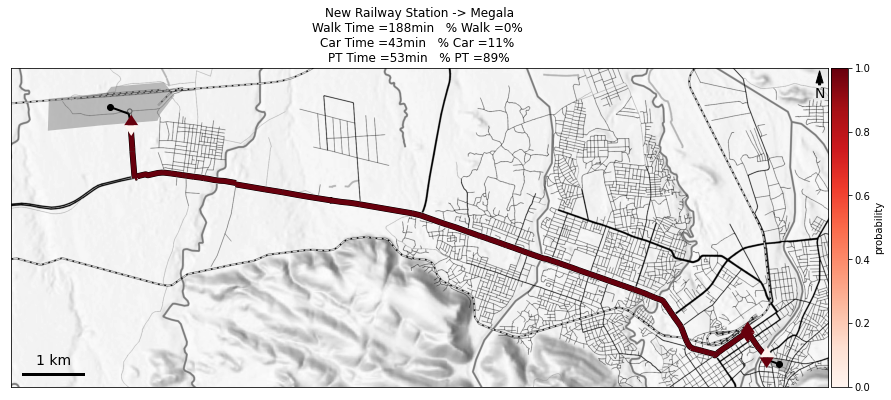

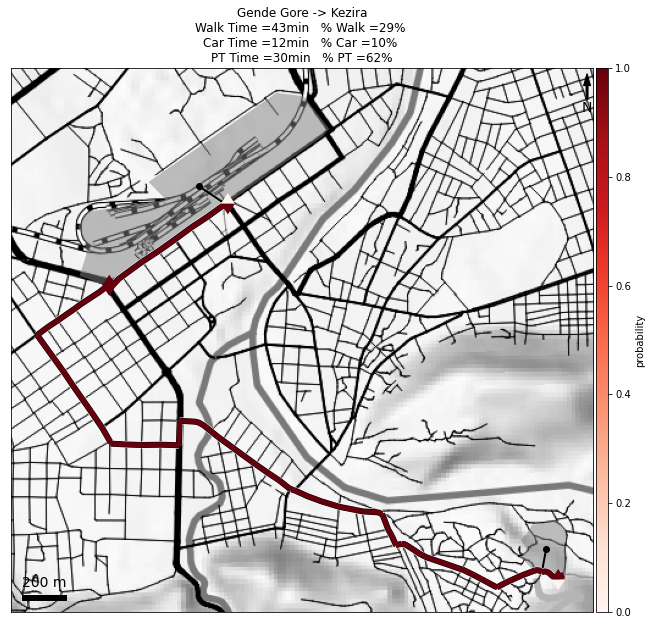

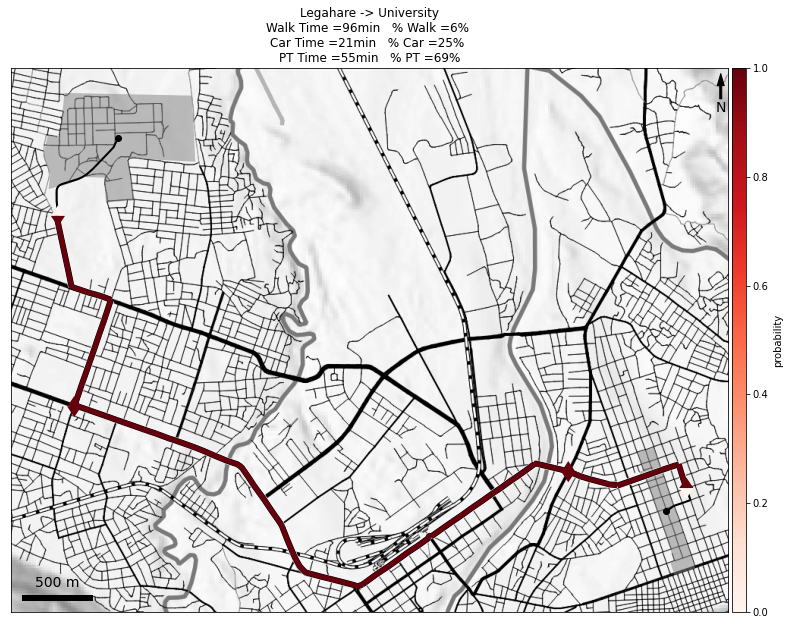

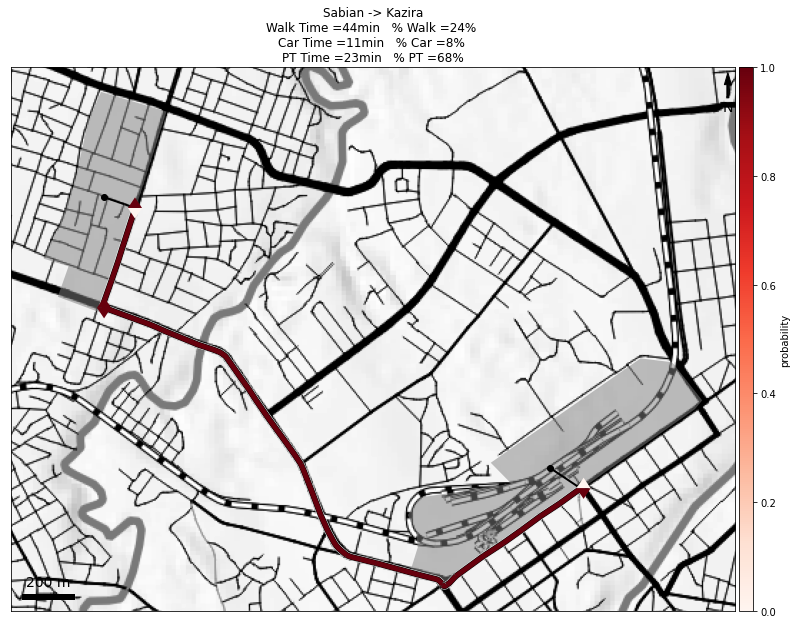

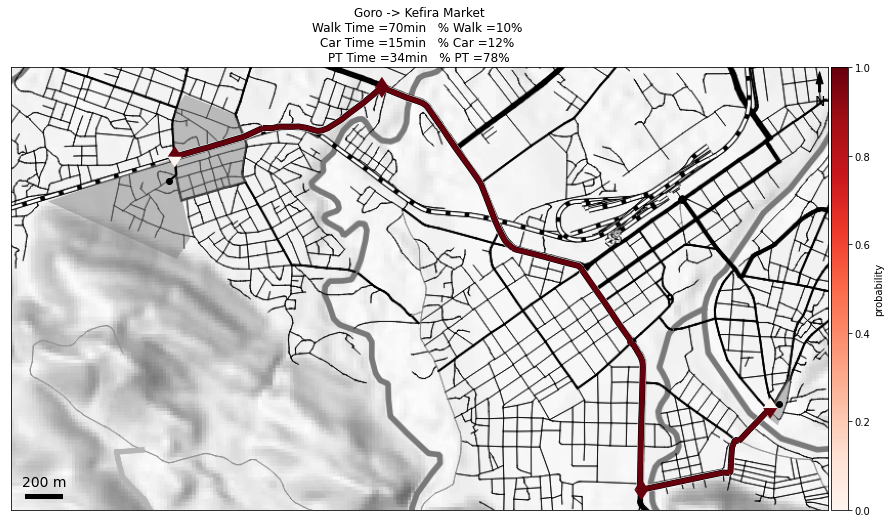

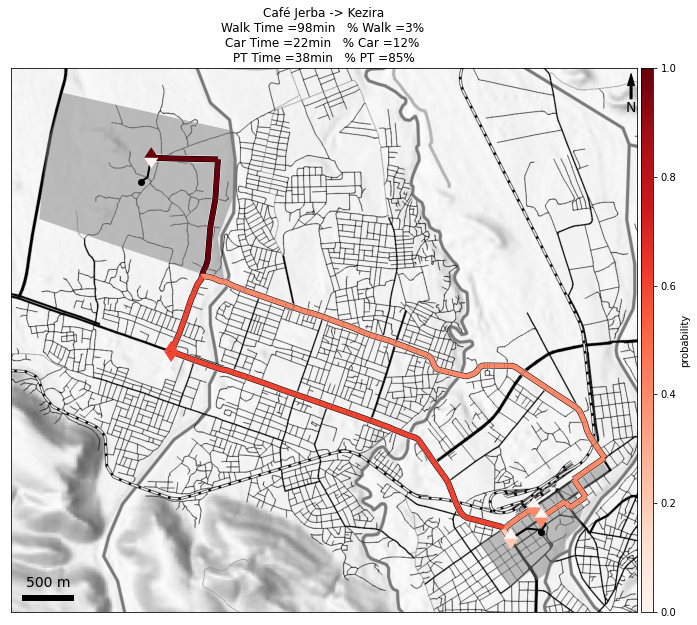

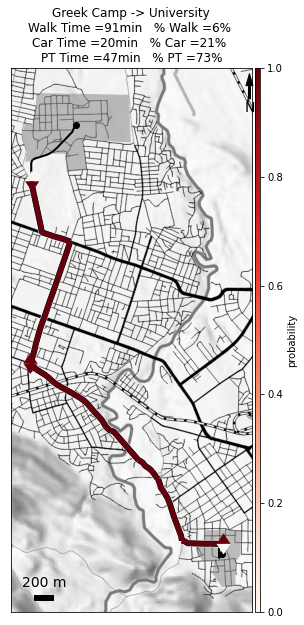

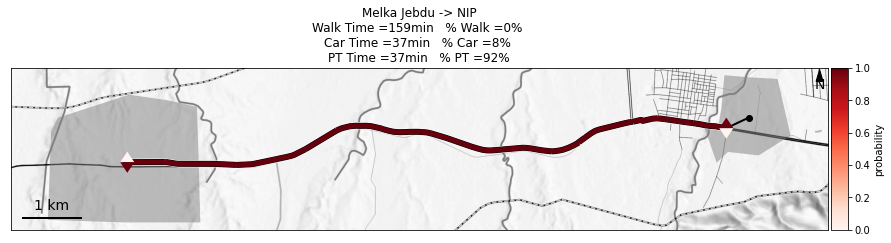

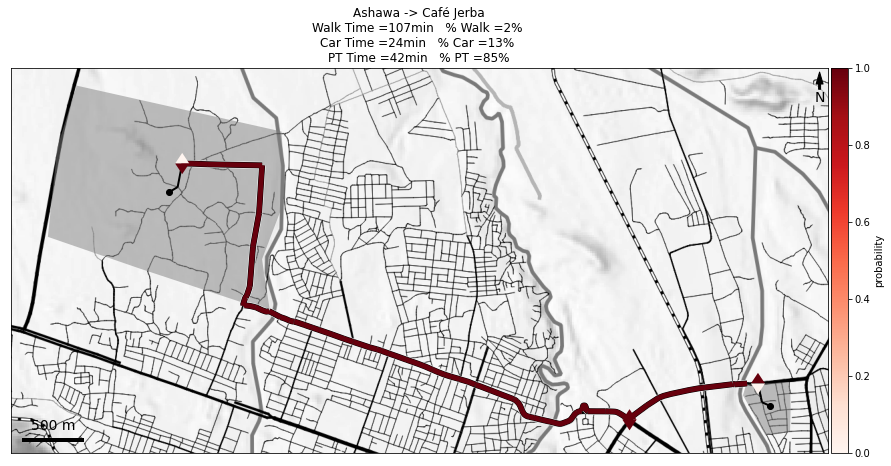

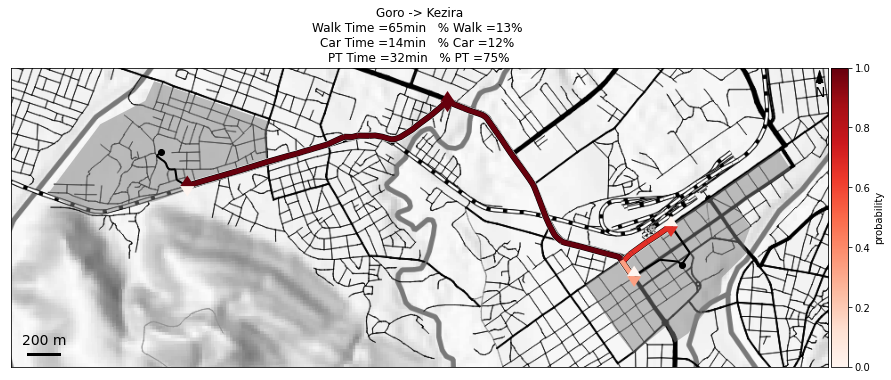

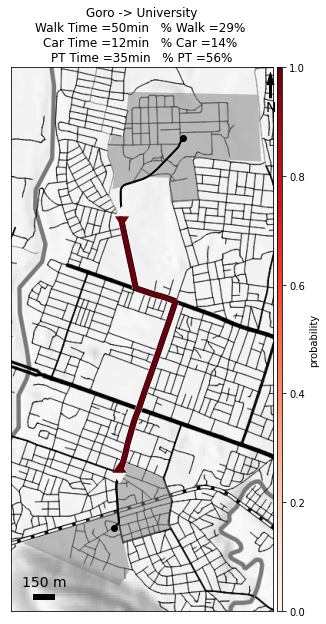

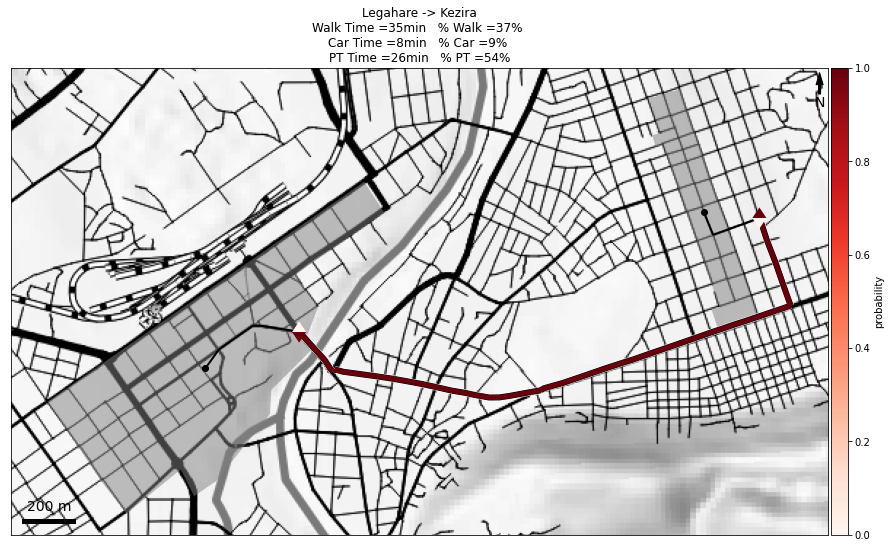

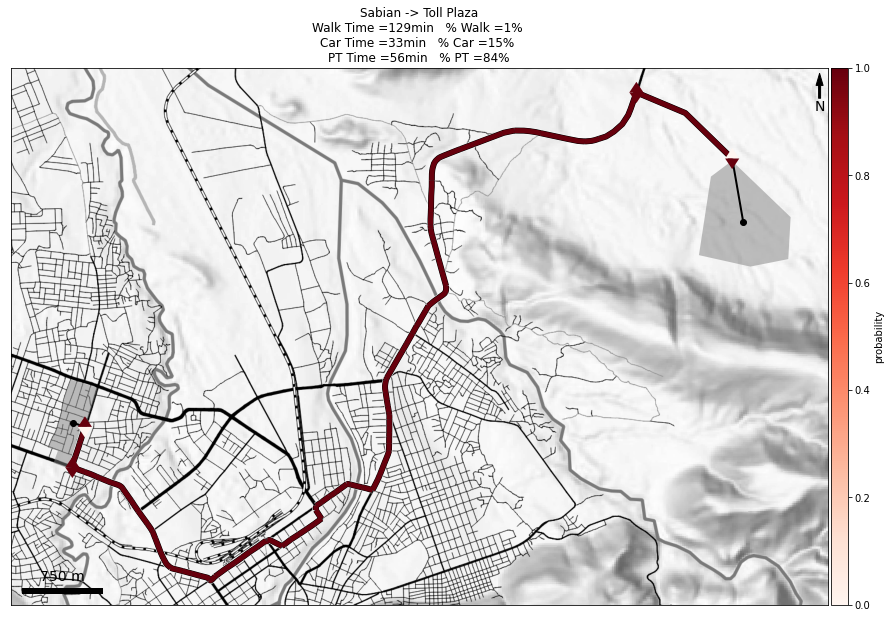

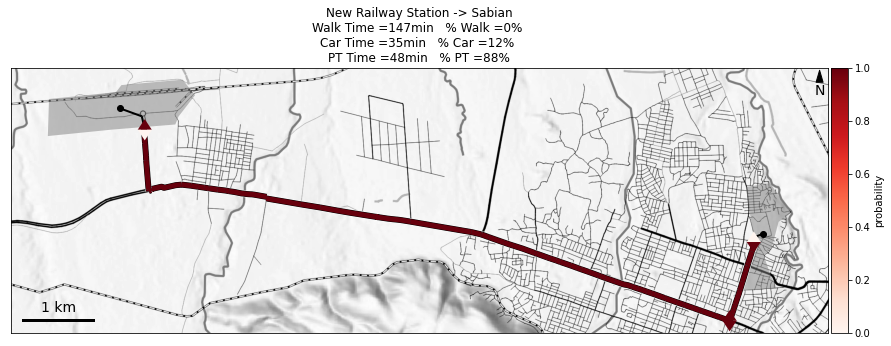

In [8]:
raster = rasterio.open(r'../../inputs/tiff/20137.tiff')#crea

#anadir columnas a la tabla OD list con informacion LOS (tiempo y reparto)

for i in od_list.index:
    origin = od_list['origin'][i]
    destination = od_list['destination'][i]
    #leer la info de las nuevas columnas y ponerlas en el titulo
    plot = ptf.plot_strategy(
        origin, destination, road=True, cmap='Reds', ax=None , walk_on_road=True,
        figsize=(15, 10), legend='right', legend_kwds={'orientation': 'vertical', 'label': 'probability'},
        basemap_raster=raster, scalebar=True, north_arrow=True)
    plot.set_title(od_list['description'][i] + '\n'+ 
                   'Walk Time =' + str(od_list['time_walk'][i]) + 'min   ' + '% Walk =' + str(round(od_list['% walk'][i]*100))+'% \n'+
                  'Car Time =' + str(od_list['time_car'][i]) + 'min   ' + '% Car =' + str(round(od_list['% car'][i]*100))+'% \n'+
                  'PT Time =' + str(od_list['time_pt'][i]) + 'min   ' + '% PT =' + str(round(od_list['% pt'][i]*100)) + '%')
    plot=plot.get_figure()
    plot.savefig(r'../../outputs/od_pairs/map_{scen}_{ind}.png'.format(scen=scenario, ind=i+1), bbox_inches='tight')

In [9]:
i=15
origin = od_list['origin'][i-1]
destination = od_list['destination'][i-1]
os.environ["PATH"] += os.pathsep + r'C:\Users\mgomezdelarosa\graphviz-2.38\release\bin/'
os.environ["PATH"] += os.pathsep + r'C:\Users\qchasserieau\dev\graphviz-2.38\release\bin/'
logic=ptf.display_aggregated_edges(origin, destination, ranksep=0.5,rankdir='LR', irrelevant_nodes=set(ptf.road_nodes.index))
logic

KeyError: 14

In [ ]:
origin = 'k2_airport_jerba'
destination = 'zone_194'

In [ ]:
plt = ptf.plot_strategy(
    origin, destination, road=True, cmap='Reds', ax=None , walk_on_road=True,
    figsize=(15, 10), legend='right', legend_kwds={'orientation': 'vertical', 'label': 'probability'},
    basemap_raster=raster, scalebar=True, north_arrow=True)

In [ ]:
os.environ["PATH"] += os.pathsep + r'C:\Users\mgomezdelarosa\graphviz-2.38\release\bin/'
os.environ["PATH"] += os.pathsep + r'C:\Users\qchasserieau\dev\graphviz-2.38\release\bin/'
log=ptf.display_aggregated_edges(origin, destination, ranksep=0.5,rankdir='LR', irrelevant_nodes=set(ptf.road_nodes.index))
log